In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import umap
from sklearn.cluster import KMeans
import plotly.graph_objects as go

In [121]:
df = pd.read_csv('Data/filtered_data.csv')

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27339 entries, 0 to 27338
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hospital Service Area             27339 non-null  object 
 1   Hospital County                   27339 non-null  object 
 2   Facility Name                     27339 non-null  object 
 3   Age Group                         27339 non-null  object 
 4   Gender                            27339 non-null  object 
 5   Race                              27339 non-null  object 
 6   Ethnicity                         27339 non-null  object 
 7   Length of Stay                    27339 non-null  float64
 8   Type of Admission                 27339 non-null  object 
 9   Patient Disposition               27339 non-null  object 
 10  Discharge Year                    27339 non-null  int64  
 11  CCSR Diagnosis Code               27339 non-null  object 
 12  CCSR

### Scaling necessary columns

In [123]:
columns_to_scale = ['APR DRG Code', 'APR MDC Code']

selected_data = df[columns_to_scale]

print("Missing values in selected_data before scaling:")
print(selected_data.isna().sum())

Missing values in selected_data before scaling:
APR DRG Code    0
APR MDC Code    0
dtype: int64


In [124]:
scaler = MinMaxScaler()

scaler.fit(selected_data)

scaled_data = scaler.transform(selected_data)

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

In [125]:
if not df.index.equals(scaled_df.index):
    scaled_df.set_index(df.index, inplace=True)

In [126]:
df[columns_to_scale] = scaled_df

### Dummy encoding and dropping the remaining unnecessary columns

In [127]:
df_encoded = pd.get_dummies(df, columns=['Hospital Service Area', 'Hospital County', 'Facility Name'
                                         , 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission'
                                         , 'Patient Disposition', 'CCSR Diagnosis Code', 'CCSR Procedure Code'
                                         , 'APR Risk of Mortality', 'APR Medical Surgical Description'
                                         , 'Emergency Department Indicator']
                            ,prefix=['Hospital Service Area', 'Hospital County', 'Facility'
                                     , 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission'
                                     , 'Patient Disposition', 'CCSR Diagnosis Code', 'CCSR Procedure Code'
                                     , 'APR Risk of Mortality', 'APR Medical Surgical Description'
                                     , 'Emergency Department Indicator'])

In [128]:
columns_to_drop_2 = ['Hospital Service Area', 'Hospital County'
                  , 'Facility Name', 'Age Group', 'Gender', 'Race', 'Ethnicity'
                  , 'Type of Admission', 'Patient Disposition', 'CCSR Diagnosis Code'
                  , 'CCSR Procedure Code', 'APR Risk of Mortality'
                  , 'APR Medical Surgical Description', 'Payment Typology 1'
                  , 'Emergency Department Indicator']

In [129]:
for col in columns_to_drop_2:
    try:
        df_encoded.drop(columns=[col], inplace=True)
    except:
        print(col)

Hospital Service Area
Hospital County
Facility Name
Age Group
Gender
Race
Ethnicity
Type of Admission
Patient Disposition
CCSR Diagnosis Code
CCSR Procedure Code
APR Risk of Mortality
APR Medical Surgical Description
Emergency Department Indicator


### Using PCA to reduce dimensionality

In [130]:
y = df_encoded['Total Charges']
X = df_encoded.drop(columns =['Total Charges'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

pca = PCA(n_components=245, random_state = 13)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Creating variables using clusters
First seeing how many clusters to use by looking at an elbow curve and CH scores

In [131]:
k_means_2 = KMeans(n_clusters=2).fit(X_train_pca)
k_means_3 = KMeans(n_clusters=3).fit(X_train_pca)
k_means_4 = KMeans(n_clusters=4).fit(X_train_pca)
k_means_5 = KMeans(n_clusters=5).fit(X_train_pca)
k_means_6 = KMeans(n_clusters=6).fit(X_train_pca)
k_means_7 = KMeans(n_clusters=7).fit(X_train_pca)

k_list = [k_means_2, k_means_3, k_means_4, k_means_5, k_means_6, k_means_7]

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/seamuswalsh/anaconda3/lib/python3.10/site-package

In [132]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(X_train_pca, labels))

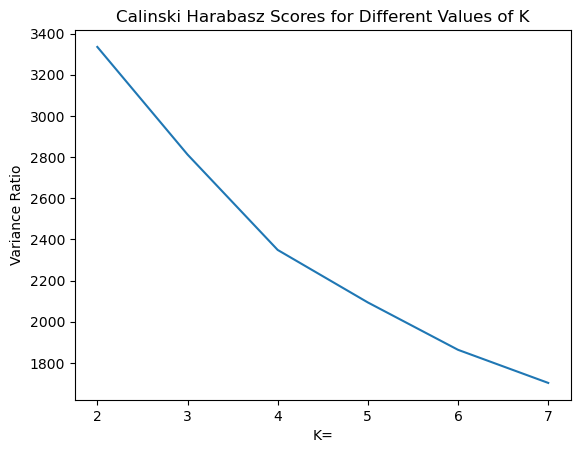

In [133]:
plt.plot([2, 3, 4, 5, 6, 7], CH_score)
plt.xticks([2,3,4,5,6,7])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

#### Not very clear, but it looks like 4 clusters might be ideal. Let's test it out.

In [134]:
kmeans = KMeans(n_clusters= 4, random_state=13)

# Fit the clustering algorithm to the reduced training data
cluster_assignments_train = kmeans.fit_predict(X_train_pca)

# Apply the same clustering to the reduced test data
cluster_assignments_test = kmeans.predict(X_test_pca)

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



#### Seeing what our clusters look like

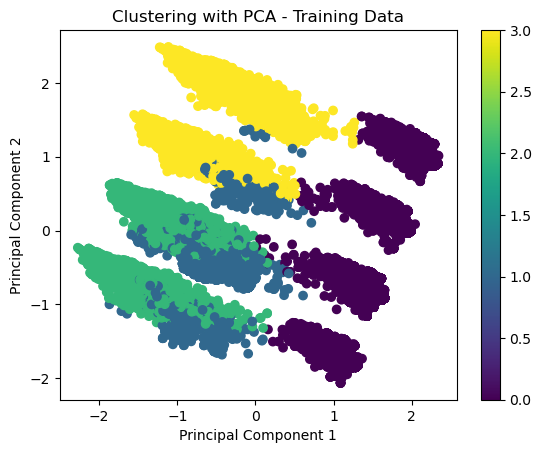

In [135]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_assignments_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with PCA - Training Data')
plt.colorbar()
plt.show()

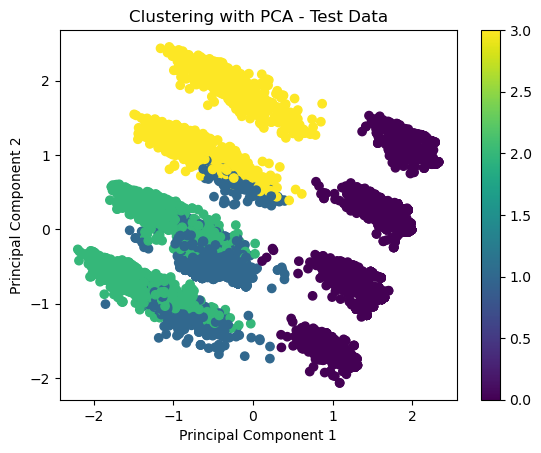

In [136]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=cluster_assignments_test, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with PCA - Test Data')
plt.colorbar()
plt.show()

#### Adding these clusters to the model

In [137]:
# Add the cluster assignments as a new feature to the training data
X_train['Cluster'] = cluster_assignments_train

# Add the cluster assignments as a new feature to the test data
X_test['Cluster'] = cluster_assignments_test

#### Testing on a Random Forest Regressor Model

In [138]:
rfr = RandomForestRegressor(random_state = 13)
rfr.fit(X_train,y_train)
print(rfr.score(X_test,y_test))

preds = rfr.predict(X_test)

0.8142503160661632


In [139]:
print(rfr.score(X_test,y_test))
mse = mean_squared_error(y_test, preds)
print("Mean Squared Error (MSE):", mse)

0.8142503160661632
Mean Squared Error (MSE): 43535774.72791617


In [140]:
import plotly.express as px
px.scatter(x = y_test, y = preds )

#### Not bad but I'm going to try using 3 clusters based on the elbow plot

In [141]:
kmeans = KMeans(n_clusters= 3, random_state=13)

# Fit the clustering algorithm to the reduced training data
cluster_assignments_train = kmeans.fit_predict(X_train_pca)

# Apply the same clustering to the reduced test data
cluster_assignments_test = kmeans.predict(X_test_pca)

/Users/seamuswalsh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



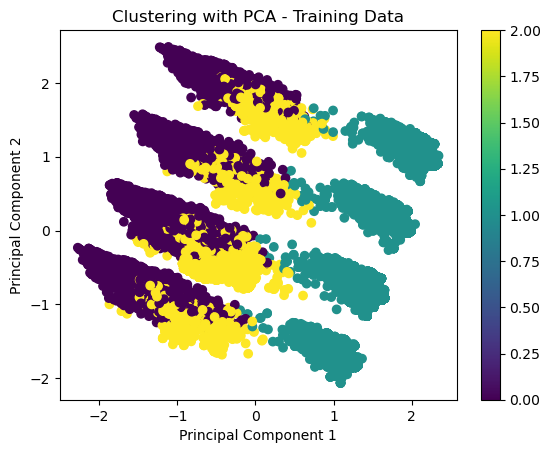

In [142]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_assignments_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with PCA - Training Data')
plt.colorbar()
plt.show()

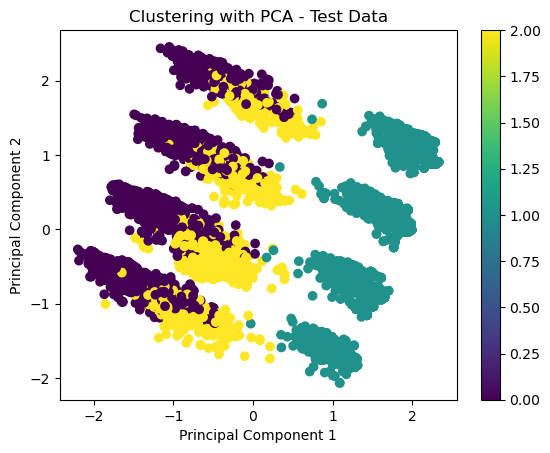

In [143]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=cluster_assignments_test, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with PCA - Test Data')
plt.colorbar()
plt.show()

In [144]:
# Add the cluster assignments as a new feature to the training data
X_train['Cluster'] = cluster_assignments_train

# Add the cluster assignments as a new feature to the test data
X_test['Cluster'] = cluster_assignments_test

In [145]:
rfr = RandomForestRegressor(random_state = 13)
rfr.fit(X_train,y_train)
print(rfr.score(X_test,y_test))

preds = rfr.predict(X_test)

0.8172020939463067


In [146]:
print(rfr.score(X_test,y_test))
mse = mean_squared_error(y_test, preds)
print("Mean Squared Error (MSE):", mse)

0.8172020939463067
Mean Squared Error (MSE): 42843940.78174081


In [147]:
import plotly.express as px
px.scatter(x = y_test, y = preds )

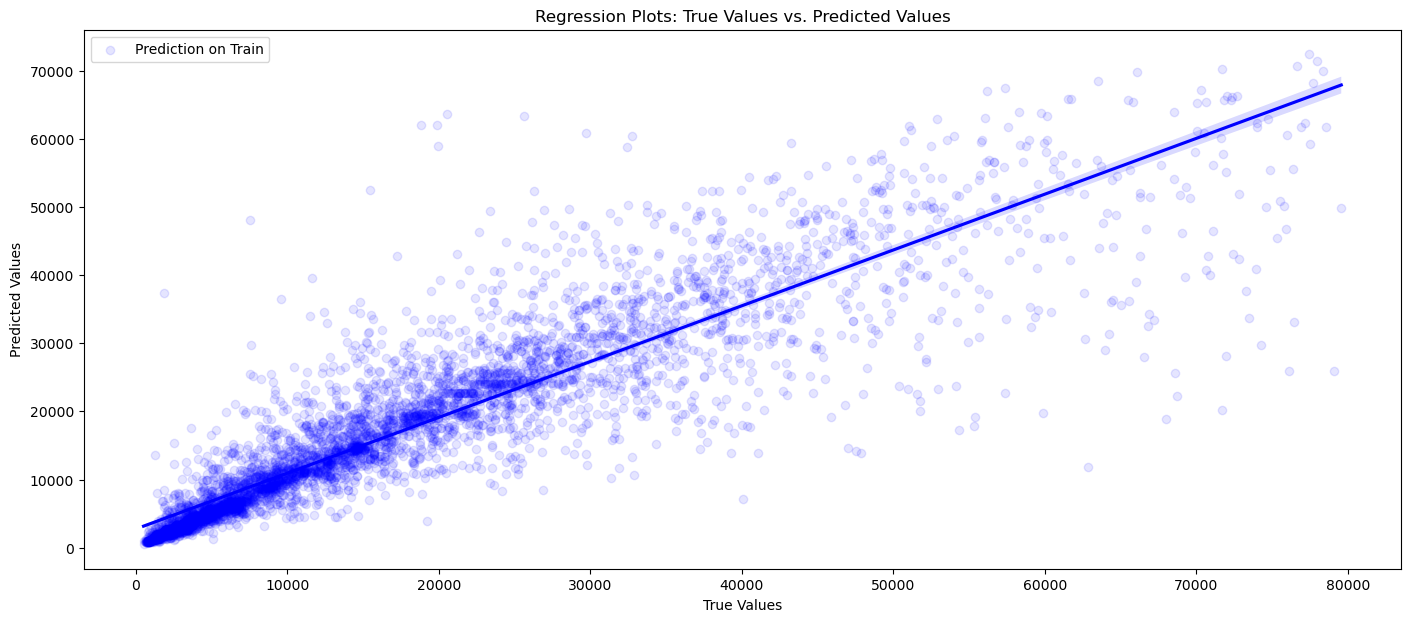

In [148]:
plt.figure(figsize=(17, 7))

# Plot the regplot for y_test and preds
sns.regplot(x=y_test, y=preds, scatter_kws={'alpha': 0.1}, label='Prediction on Train', color='blue')


plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression Plots: True Values vs. Predicted Values')
plt.show()

This looks like our best model. Reduces dimensionality and explains about 82% of the variation in the target variable. It is also the lowest MSE that I could reach, otherwise.

Looking back to my EDA, I think the size of the MSE is likely due to the large differences in charges for the same procedures across different facilities (highlighting the importance of this work). Additionally, I didn't have access to more specific ICD codes, but instead had higher level codes. I think having specific ICD codes could drastically improve this model.